In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import norm

In [2]:
ht_df = pd.read_csv(r'C:\Users\cbi7088\Oct\Hash_table.csv')
k_df = pd.read_csv(r'C:\Users\cbi7088\Oct\K_17-19.csv')
odds_df = pd.read_csv(r'C:\Users\cbi7088\Oct\Odds_17-19.csv',encoding = 'ISO-8859-1')

In [3]:
print(k_df.shape)
k_df.head()
k_df = pd.merge(k_df,ht_df,left_on='Team',right_on='Team_1')
k_df['Team & Week & Year'] = k_df.Team_2.map(str) + k_df.Week.map(str) + k_df.Year.map(str)
k_df.head()

(1008, 10)


,Week,Year,GID,Name,Pos,Team,h/a,Oppt,FD points,FD salary,Team_1,Team_2,Team & Week & Year
0,1,2017,6217,"Tavecchio, Giorgio",PK,oak,a,ten,19.0,0.0,oak,Oakland,Oakland12017
1,2,2017,6217,"Tavecchio, Giorgio",PK,oak,h,nyj,9.0,4700.0,oak,Oakland,Oakland22017
2,3,2017,6217,"Tavecchio, Giorgio",PK,oak,a,was,4.0,4800.0,oak,Oakland,Oakland32017
3,4,2017,6217,"Tavecchio, Giorgio",PK,oak,a,den,4.0,4900.0,oak,Oakland,Oakland42017
4,5,2017,6217,"Tavecchio, Giorgio",PK,oak,h,bal,5.0,4800.0,oak,Oakland,Oakland52017


In [4]:
odds_df['Favorite at Home?'] = odds_df.Favorite.apply(lambda x: 0 if x[0:3] == 'At ' else 1)
odds_df.head()

,Date & Time,Favorite,Spread,Underdog,Total,Money Odds,Week,Year,Favorite at Home?
0,9/5 8:20 ET,At Chicago,-3.0,Green Bay,46.5,-$165 +$145,1,2019,0
1,9/8 1:03 ET,At Minnesota,-3.5,Atlanta,46.5,-$190 +$165,1,2019,0
2,9/8 1:03 ET,At Philadelphia,-10.0,Washington,44.0,-$550 +$425,1,2019,0
3,9/8 1:03 ET,At NY Jets,-2.5,Buffalo,41.0,-$145 +$125,1,2019,0
4,9/8 1:03 ET,Baltimore,-7.0,At Miami,40.5,-$345 +$275,1,2019,1


In [5]:
#### Split the odds df into a df for the favorites and one for the underdog. Then remove the non appropriate column as well as
#### the money line column we can add that later if needed. Then concatenate back together

odds_df_fav = odds_df[['Date & Time', 'Favorite', 'Spread', 'Total','Week','Year','Favorite at Home?']].copy()
odds_df_fav.columns = (['Date & Time', 'Team', 'Spread', 'Total','Week','Year','Favorite at Home?'])
odds_df_fav['Favorite'] = 1

odds_df_und = odds_df[['Date & Time', 'Underdog', 'Spread', 'Total','Week','Year','Favorite at Home?']].copy()
odds_df_und.columns = (['Date & Time', 'Team', 'Spread', 'Total','Week','Year','Favorite at Home?'])
odds_df_und['Favorite'] = 0



odds_df = pd.concat([odds_df_fav, odds_df_und],ignore_index=True)

odds_df['Team at Home?'] = odds_df.Team.apply(lambda x: 0 if x[0:3] == 'At ' else 1)

odds_df.head()

,Date & Time,Team,Spread,Total,Week,Year,Favorite at Home?,Favorite,Team at Home?
0,9/5 8:20 ET,At Chicago,-3.0,46.5,1,2019,0,1,0
1,9/8 1:03 ET,At Minnesota,-3.5,46.5,1,2019,0,1,0
2,9/8 1:03 ET,At Philadelphia,-10.0,44.0,1,2019,0,1,0
3,9/8 1:03 ET,At NY Jets,-2.5,41.0,1,2019,0,1,0
4,9/8 1:03 ET,Baltimore,-7.0,40.5,1,2019,1,1,1


In [6]:
#### Remove the At designation from Team by looping through with a range of rowcount



for j, row in odds_df.iterrows():
    if odds_df['Team'][j][:3] == 'At ':
        odds_df['Team'][j] = odds_df['Team'][j][3:]
    else:
        odds_df['Team'][j] = odds_df['Team'][j]

C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
#### Add implied favorite, inplied underdog, implied points and favorite at home columns

odds_df['Implied Favorite Pts'] = odds_df['Total'].astype(float)/2 - odds_df['Spread'].astype(float)/2
odds_df['Implied Underdog Pts'] = odds_df['Total'].astype(float)/2 + odds_df['Spread'].astype(float)/2

odds_df.loc[odds_df['Favorite'] == 1, 'Implied Pts'] = odds_df['Implied Favorite Pts']
odds_df.loc[odds_df['Favorite'] == 0, 'Implied Pts'] = odds_df['Implied Underdog Pts']
odds_df['Implied Pts'] = odds_df['Implied Favorite Pts']

odds_df['Team & Week & Year'] = odds_df.Team.map(str) + odds_df.Week.map(str) + odds_df.Year.map(str)

In [8]:
print('k_df shape: ',k_df.shape)
print('odds_df shape: ',odds_df.shape)
ml_df = pd.merge(k_df,odds_df, left_on = 'Team & Week & Year', right_on = 'Team & Week & Year', how = 'inner')
ml_df.shape

k_df shape:  (1008, 13)
odds_df shape:  (1152, 13)


(1007, 25)

In [9]:
dummies = pd.get_dummies(ml_df['GID'])
#pd.merge(ml_df, dummies,)
ml_df.shape

(1007, 25)

In [10]:
dummies.shape
dummies.head()

,6016,6037,6048,6071,6093,6095,6096,6098,6104,6120,...,6427,6428,6429,6430,6431,6432,6433,6434,6436,6437
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
ml_df = pd.concat([ml_df, dummies], axis=1)

ml_df.shape

(1007, 78)

In [12]:
#### Remove all non-numeric data from ml_df ####

ml_df = ml_df.drop(['Name', 'Pos', 'Team_x', 'h/a','Oppt','Team_1','Team_2','Team & Week & Year',
                   'Date & Time', 'Team_y'], axis=1)
ml_df = ml_df.drop(['FD salary'], axis = 1)

count    1007.000000
mean        8.041509
std         4.528638
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        27.000000
Name: FD points, dtype: float64


C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


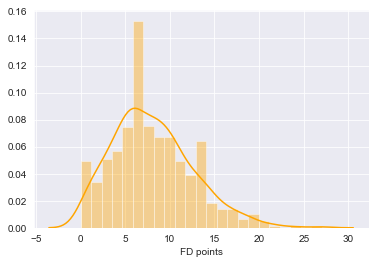

In [13]:
print(ml_df['FD points'].describe())

x1 = ml_df['FD points']

sns.set_style('darkgrid')
plot = sns.distplot(x1, color = 'orange')

In [14]:
#### Use to scale a particular column ####

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ml_df['Favorite'] = scaler.fit_transform(ml_df['Favorite'].values.reshape(-1, 1))

C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


C:\Users\cbi7088\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[ 0.58721427 -0.50344796  0.13200062 -0.07133406 -0.01239754]
Mean Absolute Error: 3.622
Root Mean Squared Error: 4.619


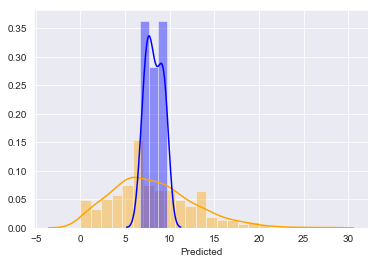

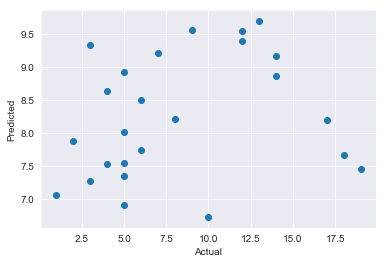

,Actual,Predicted
190,12.0,9.394439
572,9.0,9.565362
618,5.0,7.550199
971,5.0,6.905670
745,1.0,7.055089
734,14.0,9.163607
642,2.0,7.884385
194,8.0,8.215852
624,4.0,7.530258
145,7.0,9.214302


In [15]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = ml_df[['Favorite', 'Team at Home?', 'Implied Pts','Week_y', 'Spread']].values
y = ml_df['FD points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

print(regressor.coef_)

y_pred = regressor.predict(X_test)

df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result_1 = df_result.head(25)

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),3)) 
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))



#### Create overlapping histogram of prediction and actuals ####

x2 = df_result_1['Predicted']

sns.set_style('darkgrid')
plot = sns.distplot(x1,color = 'orange')
plot = sns.distplot(x2,color = 'blue')



#### Create scatter plot of prediction vs actuals ####

fig, ax = plt.subplots()
x = df_result_1['Actual']
y = df_result_1['Predicted']
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.scatter(x, y)

ax.grid(True)
plt.show()


df_result_1

In [16]:
print('Different kickers: ',ml_df.GID.value_counts().count())
#ml_df.GID.value_counts()


Different kickers:  53


In [17]:
#### Publish correlations and overall ml_df data to csv

cor = ml_df[ml_df.columns[0:]].corr()['FD points'][:].abs().sort_values(ascending=False)
cor.to_csv('cor.csv')
ml_df.to_csv('ml_df.csv')
cor

FD points               1.000000
Favorite                0.157312
6205                    0.150818
6423                    0.107303
Team at Home?           0.091566
6240                    0.080703
6239                    0.080138
6206                    0.079637
6096                    0.077110
Implied Favorite Pts    0.074777
Implied Pts             0.074777
6098                    0.074634
6203                    0.070220
Week_y                  0.070008
Week_x                  0.070008
Total                   0.060363
6427                    0.059063
6227                    0.056694
6430                    0.055427
6217                    0.054483
6230                    0.052439
6166                    0.051808
6071                    0.049155
6434                    0.049047
6425                    0.049047
6424                    0.047383
6243                    0.045922
6229                    0.044251
Spread                  0.042770
6429                    0.040528
          